In [6]:
from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from seasalt.seasalt import (
    pipe,
    apply_salt_pepper,
    fixed_window_outlier_filter,
    anisotropic_diffusion,
    get_edges,
    plot_denoise,
skeletonize_custom
)
import numpy as np

path_to_images = Path().resolve().joinpath("BSDS300-test")
image_paths = glob(f"{str(path_to_images)}/*.jpg")

im = Image.open(image_paths[16])

In [7]:
def plot_single_image(seasoned_arr, m=255):
    fig = plt.figure(
        figsize=(
            10,
            20,
        ),
        dpi=80,
    )
    gs = fig.add_gridspec(1, 1, hspace=0.12, wspace=0.08)
    ax = gs.subplots(sharex="col", sharey="row")
    ax.imshow(
    seasoned_arr, cmap="gray", vmin=0, vmax=m)
    ax.set_axis_off()

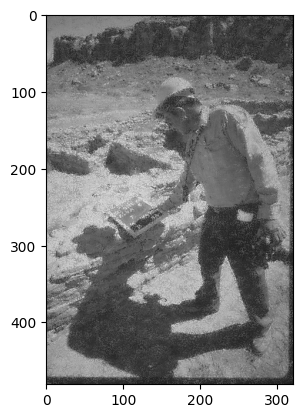

In [8]:
im_gs = im.convert("L")
arr = np.array(im_gs)
seasoned_arr = apply_salt_pepper(arr, ratio=0.4)
corrected_image = pipe(seasoned_arr, 9)
plt.imshow((corrected_image), cmap="gray", vmin=0, vmax=255)

array([[ 60,  77,  81, ..., 125, 141, 138],
       [ 75,  90,  93, ..., 123, 131, 130],
       [ 75,  85,  88, ..., 133, 137, 141],
       ...,
       [152, 146, 140, ...,  72,  63,  58],
       [163, 161, 152, ...,  54,  45,  39],
       [162, 160, 158, ...,  35,  41,  36]], dtype=uint8)

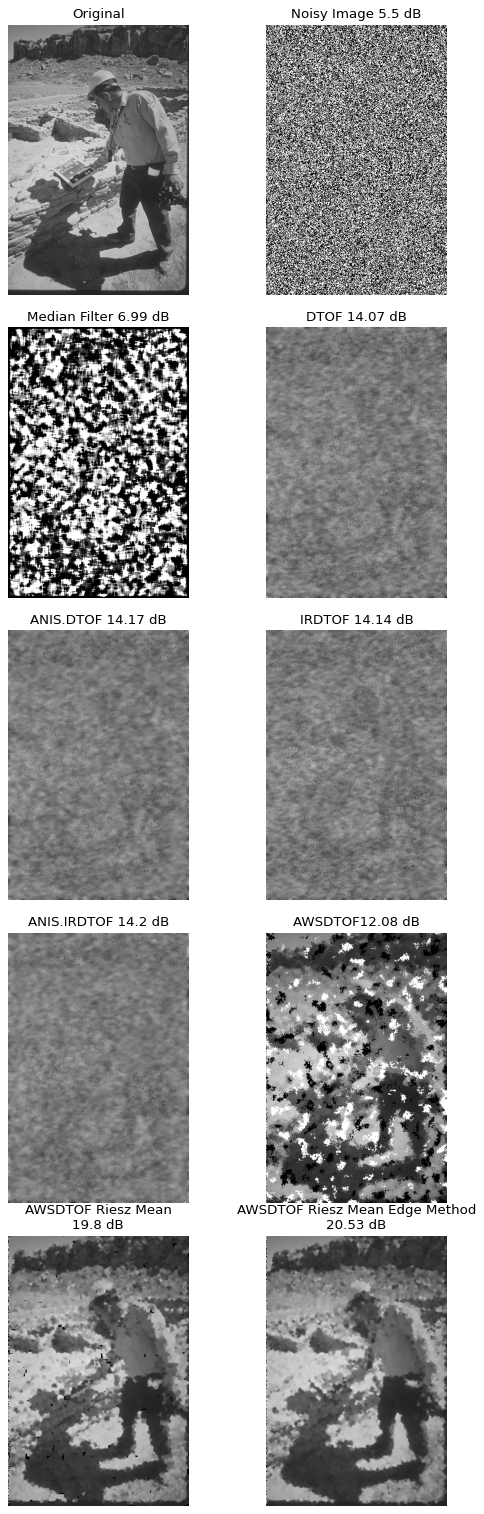

In [9]:
plot_denoise(im, sp_ratio=0.95, size=9)


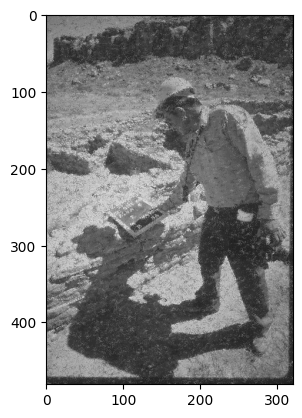

In [10]:
corrected_img = fixed_window_outlier_filter(seasoned_arr, 5)
plt.imshow(corrected_img,cmap="gray", vmin=0, vmax=255)

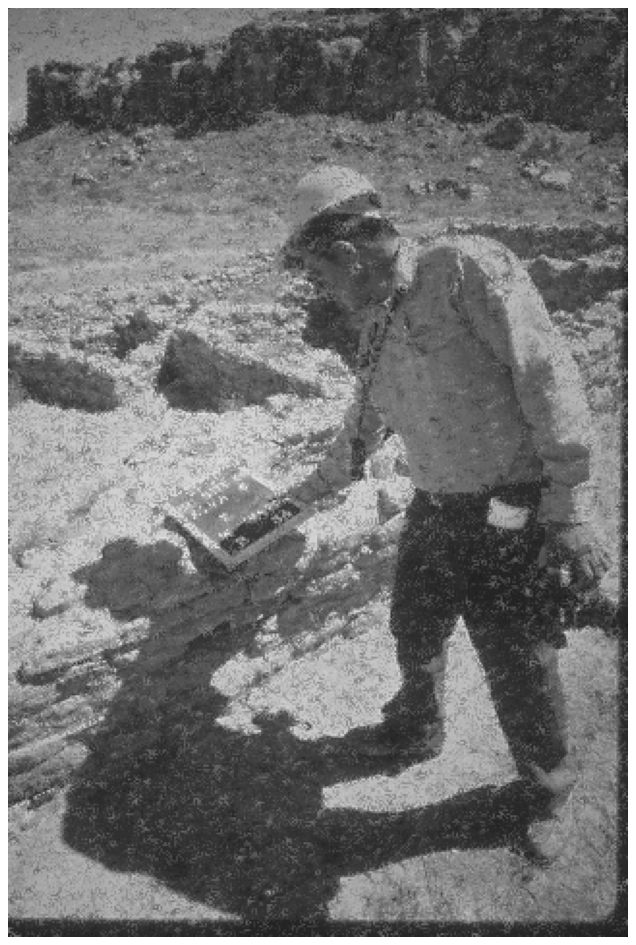

In [11]:
plot_single_image(corrected_img)

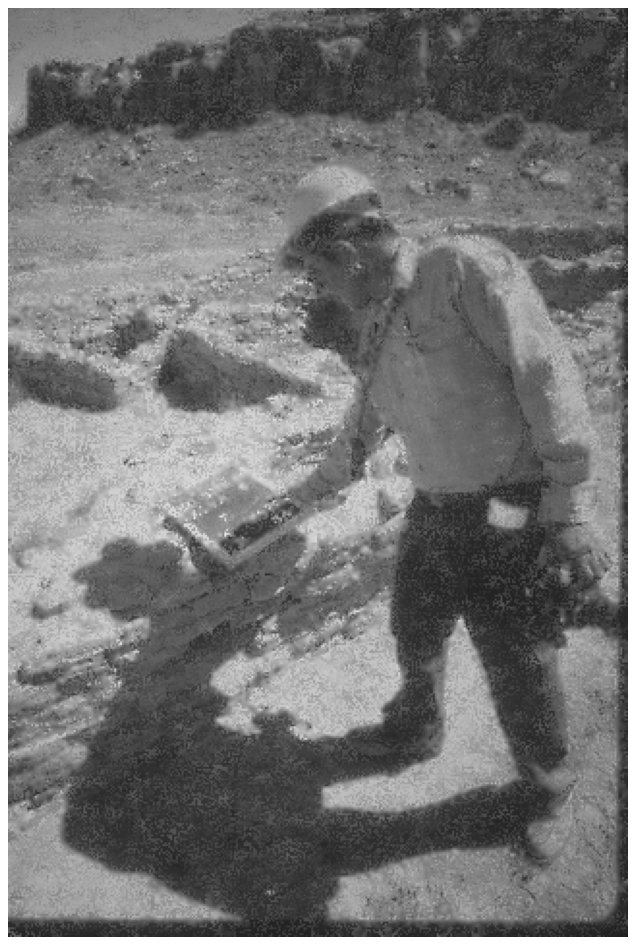

In [12]:
from seasalt.seasalt import get_c
corrected_img = fixed_window_outlier_filter(seasoned_arr, 9)
mask = skeletonize_custom(get_edges(corrected_img))
base = fixed_window_outlier_filter(corrected_img, 9, mask=mask)

plot_single_image(
    np.ma.filled(np.where(base.mask, cv2.GaussianBlur(
        fixed_window_outlier_filter(corrected_img, 9, mask=~mask).astype(np.uint8),
        (3, 3),
        0,
    ), base))
   
    )

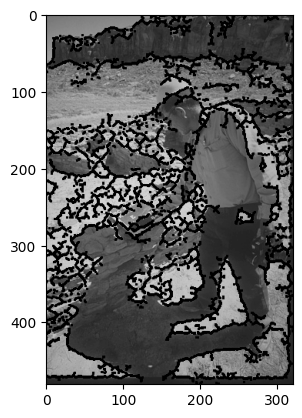

In [13]:

corrected_img = fixed_window_outlier_filter(seasoned_arr, 5)
edges_mask = get_edges(corrected_img)
skeletonized_mask = skeletonize_custom(edges_mask)
plt.imshow(np.where(skeletonized_mask == 0, arr, 0),cmap="gray", vmin=0, vmax=255)

array([[140, 123, 111, ...,  61,  47,  33],
       [139, 116, 121, ...,  45,  40,  38],
       [117, 116, 117, ...,  37,  35,  37],
       ...,
       [ 63,  38,  49, ...,  34,  32,  35],
       [ 36,  37,  38, ...,  34,  34,  34],
       [ 36,  37,  37, ...,  35,  33,  33]], dtype=uint8)

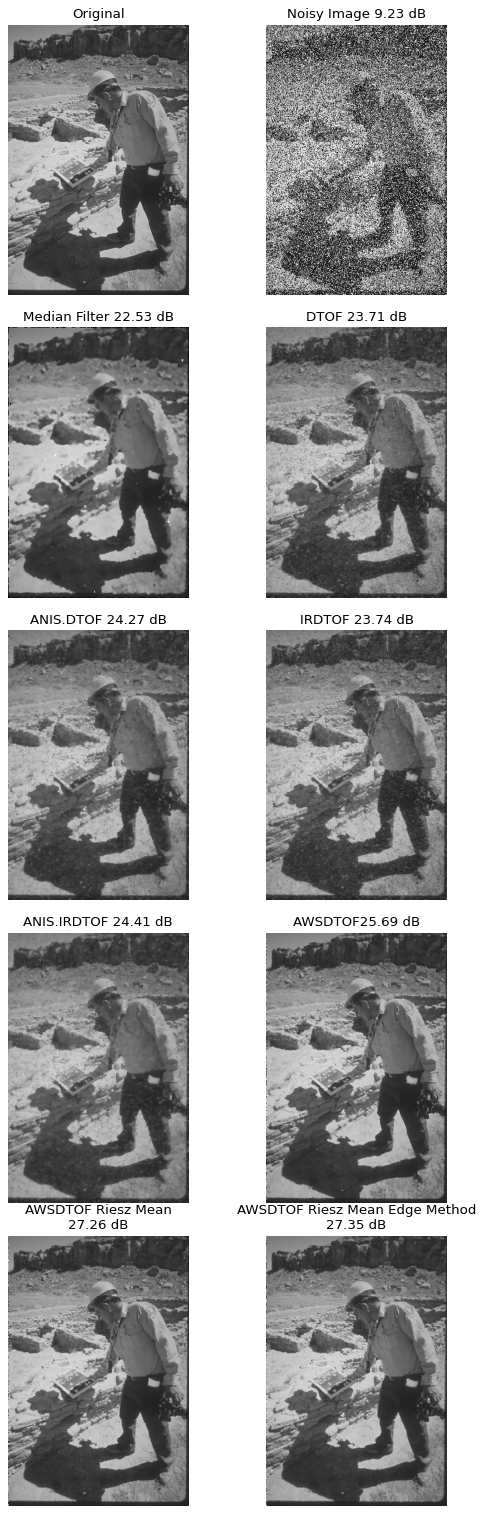

In [14]:
plot_denoise(im=im_gs,sp_ratio=.4,size=5)

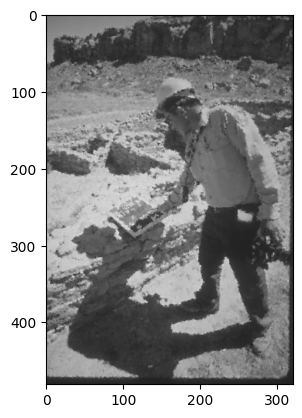

In [15]:
from seasalt.seasalt import adaptive_kernel_size

seasoned_arr = apply_salt_pepper(arr, ratio=.7)
corrected_adaptive_window = adaptive_kernel_size(
    seasoned_arr, 5
)
plt.imshow(corrected_adaptive_window, cmap="gray", vmin=0, vmax=255)


In [16]:
import itertools
def DAMRmF(A):
    A = np.double(A)
    for p in range(5, 0, -1):
        pA = np.pad(A, ((p, p), (p, p)), "symmetric")
        m, n = pA.shape
        pB = (pA != 0) & (pA != 255)
        for i in range(1 + p, m - p):
            for j in range(1 + p, n - p):
                if pB[i, j] == 0:
                    for k in range(1, p + 1):
                        if (
                            np.median(
                                np.median(pA[i - k : i + k, j - k : j + k])
                            )
                            > 0
                            and np.median(
                                np.median(pA[i - k : i + k, j - k : j + k])
                            )
                            < 255
                            and pA[i, j] in [0, 255]
                        ):
                            Wk = pA[i - k : i + k, j - k : j + k]
                            A[i - p, j - p] = MRmean(Wk)
                            break
    return np.uint8(A)


def MRmean(W1):
    n, _ = W1.shape
    k = (n - 1) // 2
    uk = 0
    qk = 0
    for s, t in itertools.product(range(n), range(n)):
        if W1[s, t] not in [0, 255]:
            pw = 1 / (1 + ((k + 1 - s) ** 2 + (k + 1 - t) ** 2)) ** 2
            uk = uk + pw * W1[s, t]
            qk = qk + pw
    return uk / qk if qk > 0 else 0


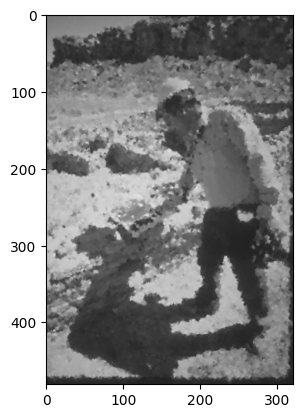

In [17]:

from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from seasalt.seasalt import adaptive_kernel_size,apply_salt_pepper
import numpy as np
path_to_images = Path().resolve().joinpath("BSDS300-test")
image_paths = glob(f"{str(path_to_images)}/*.jpg")

im = Image.open(image_paths[16])
im_gs = im.convert("L")
arr = np.array(im_gs)
seasoned_arr = apply_salt_pepper(arr, ratio=0.9)
plt.imshow(
    (adaptive_kernel_size(seasoned_arr.astype(np.uint8))), cmap="gray", vmin=0, vmax=255)

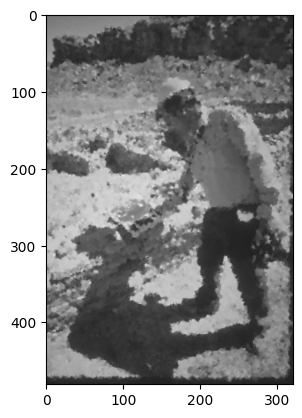

In [18]:
plt.imshow((pipe(seasoned_arr, 5,func=adaptive_kernel_size)), cmap="gray", vmin=0, vmax=255)